# XML Gas Stations Data Exploration

## Constants and libraries

In [1]:
import pandas as pd
import xmltodict as x2d
import matplotlib.pyplot as plt

DATA_FOLDER = 'data/'
DATASET_1_FILE_1 = DATA_FOLDER + 'places.xml'
DATASET_1_FILE_2 = DATA_FOLDER + 'prices.xml'
DF_COLS = ['place_id', 'name', 'cre_id', 'longitude', 'latitude', 'regular_price', 'diesel_price', 'premium_price']   # Longitude: X - Latitude : Y

## Importing the datasets

In [2]:
places_and_prices = {}

with open(DATASET_1_FILE_1, encoding='utf8') as dataset:
    xml_tree = x2d.parse(dataset.read())

    places_list = xml_tree['places']['place']

    for place in places_list:
        pid = int(place['@place_id'])
        if not places_and_prices.get(pid):
            places_and_prices[pid] = {} 
        places_and_prices[pid]['name'] = place['name']
        places_and_prices[pid]['cre_id'] = place['cre_id']
        places_and_prices[pid]['longitude'] = place['location']['x']
        places_and_prices[pid]['latitude'] = place['location']['y']

In [3]:
with open(DATASET_1_FILE_2, encoding='utf8') as dataset:
    xml_tree = x2d.parse(dataset.read(), force_list = ('gas_price',))

    prices_list = xml_tree['places']['place']

    for price in prices_list:
        pid = int(price['@place_id'])
        
        if not places_and_prices.get(pid):
            places_and_prices[pid] = {}

        gas_prices = price['gas_price']

        for g_price in gas_prices:            
            places_and_prices[pid][f'{g_price["@type"]}_price'] = float(g_price['#text'])

stations_df = pd.DataFrame.from_dict(places_and_prices, orient = 'index')
stations_df.head()

,name,cre_id,longitude,latitude,regular_price,premium_price,diesel_price
2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.9214,32.47641,17.95,19.45,18.45
2040,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.3037,18.39,18.99,18.99
2041,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.4514,31.71947,13.28,14.05,NaN
2042,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.3042,20.71413,19.09,19.72,18.94
2043,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,14.99,16.49,NaN


## Checking for null values

In [4]:
stations_complete_data_df = stations_df[stations_df['latitude'].notna() & stations_df['longitude'].notna() & (stations_df['regular_price'].notna() | stations_df['premium_price'].notna() | stations_df['diesel_price'].notna())]

stations_complete_data_df.head()

,name,cre_id,longitude,latitude,regular_price,premium_price,diesel_price
2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.9214,32.47641,17.95,19.45,18.45
2040,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.3037,18.39,18.99,18.99
2041,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.4514,31.71947,13.28,14.05,NaN
2042,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.3042,20.71413,19.09,19.72,18.94
2043,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,14.99,16.49,NaN


In [5]:
len(stations_df.index) - len(stations_complete_data_df.index)

296

Only 296 records were dropped

## Data visualization

Text(0, 0.5, '$MXN')

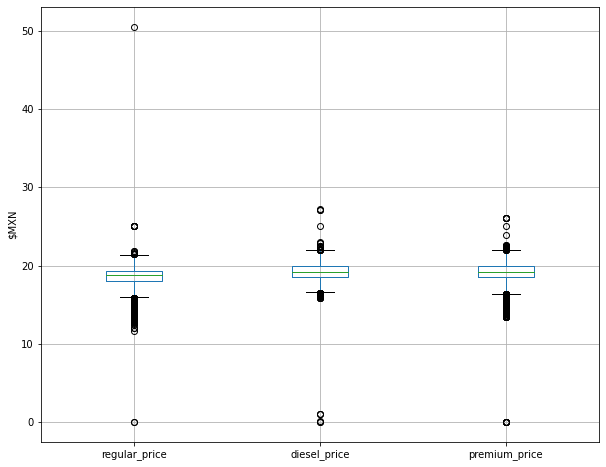

In [6]:
plt.figure(figsize = (10, 8))

ax = stations_complete_data_df.boxplot(column = ['regular_price', 'diesel_price', 'premium_price'])
ax.set_ylabel('$MXN')

In [7]:
stations_complete_data_df[['regular_price', 'diesel_price', 'premium_price']].describe()

,regular_price,diesel_price,premium_price
count,12389.000000,9268.000000,11550.000000
mean,18.531397,19.201075,19.072401
std,1.395479,1.103252,1.361956
min,0.010000,0.010000,0.010000
25%,17.990000,18.590000,18.490000
50%,18.780000,19.190000,19.140000
75%,19.370000,19.940000,19.890000
max,50.500000,27.270000,26.060000


There are two big outliers causing noise in the data: a minimum value of 0.01 and a maximum value of 50.5

As these values are incorrect, they will be discarded.

In [8]:
bad_records = stations_complete_data_df[(stations_complete_data_df['regular_price'] <= 1) | (stations_complete_data_df['diesel_price'] <= 1) | (stations_complete_data_df['premium_price'] <= 1) | (stations_complete_data_df['regular_price'] >= 40) | (stations_complete_data_df['diesel_price'] >= 40) | (stations_complete_data_df['premium_price'] >= 40)]

print(f'{len(bad_records.index)} records found with extreme values')

12 records found with extreme values


Text(0, 0.5, '$MXN')

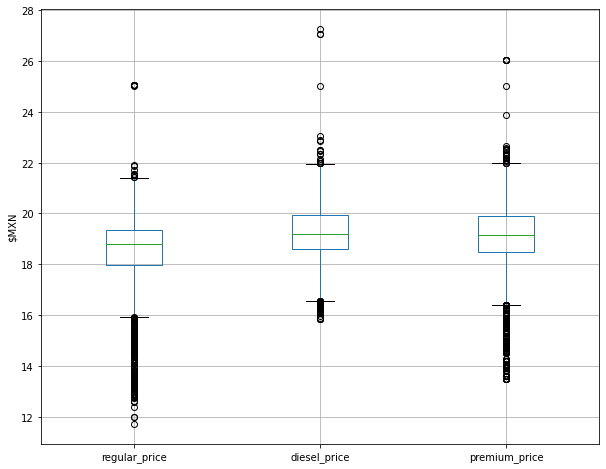

In [9]:
stations_complete_data_df.drop(bad_records.index, inplace = True)

plt.figure(figsize = (10, 8))

ax = stations_complete_data_df.boxplot(column = ['regular_price', 'diesel_price', 'premium_price'])
ax.set_ylabel('$MXN')

In [10]:
stations_complete_data_df[['regular_price', 'diesel_price', 'premium_price']].describe()

,regular_price,diesel_price,premium_price
count,12377.000000,9256.000000,11539.000000
mean,18.532162,19.213282,19.083593
std,1.345322,0.995913,1.278901
min,11.710000,15.850000,13.490000
25%,17.990000,18.590000,18.490000
50%,18.780000,19.190000,19.140000
75%,19.370000,19.940000,19.890000
max,25.050000,27.270000,26.060000


In [11]:
stations_complete_data_df['name'].str.len().max()

91

In [12]:
stations_complete_data_df.index.names = ['id']
stations_complete_data_df.reset_index(level = 'id', inplace = True)

In [13]:
stations_complete_data_df.head().to_dict('records')

[{'id': 2039,
  'name': 'ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.',
  'cre_id': 'PL/658/EXP/ES/2015',
  'longitude': '-116.9214',
  'latitude': '32.47641',
  'regular_price': 17.95,
  'premium_price': 19.45,
  'diesel_price': 18.45},
 {'id': 2040,
  'name': 'DIGEPE, S.A. DE C.V. (07356)',
  'cre_id': 'PL/902/EXP/ES/2015',
  'longitude': '-99.74484',
  'latitude': '20.3037',
  'regular_price': 18.39,
  'premium_price': 18.99,
  'diesel_price': 18.99},
 {'id': 2041,
  'name': 'DIAZ GAS, S.A. DE C.V.',
  'cre_id': 'PL/760/EXP/ES/2015',
  'longitude': '-106.4514',
  'latitude': '31.71947',
  'regular_price': 13.28,
  'premium_price': 14.05,
  'diesel_price': nan},
 {'id': 2042,
  'name': 'COMBU-EXPRESS, S.A. DE C.V.',
  'cre_id': 'PL/825/EXP/ES/2015',
  'longitude': '-103.3042',
  'latitude': '20.71413',
  'regular_price': 19.09,
  'premium_price': 19.72,
  'diesel_price': 18.94},
 {'id': 2043,
  'name': 'PETROMAX, S.A. DE C.V.',
  'cre_id': 'PL/585/EXP/ES/2015',
  'longitude': '-98.2997

In [15]:
stations_complete_data_df['geopair'] = stations_complete_data_df["longitude"].astype(str) + ',' + stations_complete_data_df["latitude"].astype(str)
stations_complete_data_df['geopair'].head().to_list()

['-116.9214,32.47641',
 '-99.74484,20.3037',
 '-106.4514,31.71947',
 '-103.3042,20.71413',
 '-98.29977,26.03787']

In [32]:
def draw_histogram(column):
    plt.figure(figsize = (20, 10))
    axeslist = stations_complete_data_df.hist([column])
    axeslist.flatten()[0].set_xlabel('Price ($MXN)')
    axeslist.flatten()[0].set_ylabel('Frequency')
    axeslist.flatten()[0].set_title(column.replace('_', ' ').capitalize())

<Figure size 1440x720 with 0 Axes>

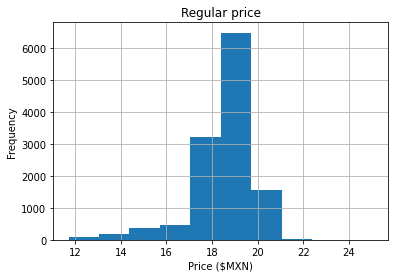

In [33]:
draw_histogram('regular_price')

<Figure size 1440x720 with 0 Axes>

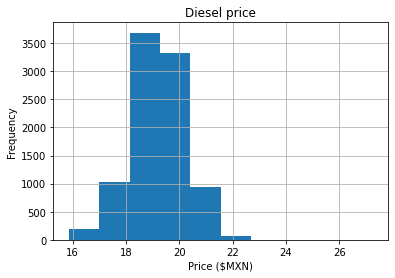

In [34]:
draw_histogram('diesel_price')

<Figure size 1440x720 with 0 Axes>

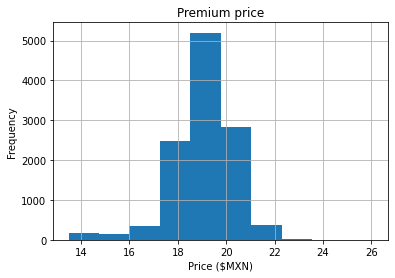

In [35]:
draw_histogram('premium_price')